In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.utils import save_image

from torch.utils.data import DataLoader

print('DONE')

DONE


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size, features):
        super(Discriminator, self).__init__()
        self.Layers = nn.Sequential(
            nn.Conv2d(input_size, features, kernel_size=4, stride=2, padding=1),  #,bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid() 
        )
    def forward(self, x):
        return self.Layers(x)

class Generator(nn.Module):
    def __init__(self, input_size, image_channels, features):
        super(Generator, self).__init__()
        self.Layers = nn.Sequential(
            nn.ConvTranspose2d(input_size, features*16, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features*16),
            nn.ReLU(),

            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh() 
        )
    
    def forward(self, x):
        return self.Layers(x)
print('DONE')

DONE


In [ ]:
def init_weights(model, min_limit=0.0, max_limit=0.02):
    for i in model.modules():
        if isinstance(i ,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(i.weight.data, min_limit, max_limit)
print('DONE')

DONE


In [ ]:
def generate_examples(gen, n=10, phase='mid-training', noise=None, off=False):
    if noise == None:
        print('Assign "noise" a value')
        return None
    global IMG_VERSION
    gen.eval()
    for i in range(n):
      with torch.no_grad():
        img = gen(noise)
        save_image(img*0.5+0.5, f"{EXAMPLES}/img_{IMG_VERSION}+{i}-{phase}.png")
    print(f"Saving {n} example images is done.")
    if not off:
        IMG_VERSION+=1
    gen.train()

def generate_examples_over(gen, n=10, phase='Training-is-DONE', off=False):
    global IMG_VERSION
    gen.eval()
    for i in range(n):
      with torch.no_grad():
        noise = torch.randn(1,  Z_DIM, 1, 1).to(DEVICE)
        img = gen(noise)
        save_image(img*0.5+0.5, f"{EXAMPLES}/img_{IMG_VERSION}+{i}-{phase}.png")
    print(f"Saving {n} example images is done.")
    if not off:
        IMG_VERSION+=1
    gen.train()
print('DONE')

DONE


In [ ]:
def test():
    NUMBER_EXAMPLES = 8
    input = 3 #rgb
    HIGHT = 64
    WIDTH = 64
    Z_DIM = 100

    x = torch.randn((NUMBER_EXAMPLES, input, HIGHT, WIDTH))

    Discriminator_ = Discriminator(input, 8) 
    init_weights(Discriminator_)

    Generator_ = Generator(Z_DIM, input, 8)
    init_weights(Generator_)

    noise = torch.randn((NUMBER_EXAMPLES, Z_DIM, 1, 1))
    
    assert Discriminator_(x).shape == (NUMBER_EXAMPLES, 1, 1, 1) 
    print('Discriminator --> PASSED') 

    assert Generator_(noise).shape == (NUMBER_EXAMPLES, input, HIGHT, WIDTH)
    print('Generator --> PASSED\nSuccess')

test()
print('DONE')

Discriminator --> PASSED
Generator --> PASSED
Success
DONE


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('GPU on:', True if torch.cuda.is_available() else False, '| Device:',DEVICE)

LR = 0.0002
BATCH_SIZE = 128
IMAGE_SIZE = 64
IMAGE_CHANNELS = 3
Z_DIM =100
EPOCHS = 1000
FEAT_DISC = 64
FEAT_GENA = 64
##
LR = 0.0002
BATCH_SIZE = 64
IMAGE_SIZE = 64
IMAGE_CHANNELS = 3
Z_DIM =100
EPOCHS = 1000
FEAT_DISC = 256
FEAT_GENA = 256
##
DATA_PATH = '/content/drive/MyDrive/data'
IMG_VERSION = 0
#Fixed Noise
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)
EXAMPLES = '/content/drive/MyDrive/Colab Notebooks/DCGAN-EXAMPLES'

GPU on: True | Device: cuda


In [ ]:
transforms_ = transforms.Compose(
    [
     transforms.Resize(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
print('DONE')

DONE


In [19]:

dataset = datasets.ImageFolder(root=DATA_PATH , transform=transforms_)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#GENERATOR
gena = Generator(Z_DIM, IMAGE_CHANNELS, FEAT_GENA).to(DEVICE)
init_weights(gena)
gena_optim = optim.Adam(gena.parameters(), lr=LR, betas=(0.0, 0.99))

#DISCRIMINATOR
disc = Discriminator(IMAGE_CHANNELS, FEAT_DISC).to(DEVICE)
init_weights(disc)
disc_optim = optim.Adam(disc.parameters(),lr=LR, betas=(0.0, 0.99))

#LOSS
crite = nn.BCELoss()

#Rreparing for training
gena.train()
disc.train()

for epoch in range(EPOCHS):
    for i, (real, _) in enumerate(loader):
        #1 getting the data: fake 
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(DEVICE)
        fake = gena(noise)
        #2 getting the data: real
        real = real.to(DEVICE)

        #DISC
        disc_real = disc(real).reshape(-1)
        loss_real = crite(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_fake = crite(disc_fake, torch.zeros_like(disc_fake))

        loss_disc = (loss_real + loss_fake) / 2 #### remove?
         
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        disc_optim.step()

        #GENA
        out = disc(fake).reshape(-1)

        loss_gena = crite(out, torch.ones_like(out))

        gena.zero_grad()
        loss_gena.backward()
        gena_optim.step()

        if not i % 20:
            print(f'Epoch({epoch}/{EPOCHS}) | BATCH({i}/{len(loader)}) | Loss_D({loss_disc}) | Loss_G({loss_gena})')
            generate_examples(gena, n=2, phase='mid-training', noise=fixed_noise, off=True)

    generate_examples_over(gena, n=5, phase='epoch-training', off=True)

generate_examples_over(gena, n=100, phase='training-is-done', off=True)
print('Done Training - the output of the training was removed for the ease of navigating the notebook')

Done Training - the output of the training was removed for the ease of navigating the notebook


 **The images below were the output/generated after ~100 epochs.<br>
The model ran for 500 epochs accidently and not much improvement was shown/apparen** 
<br>
<br>
**~100 epochs:**

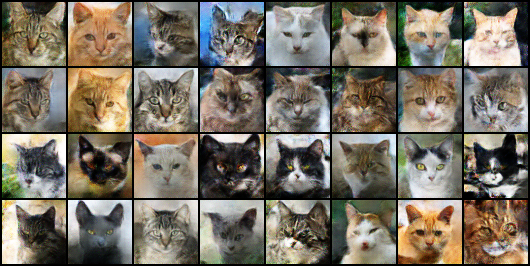

**Single output/generated**

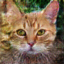

**Single output/generated**

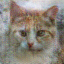

**Single output/generated at the end of training (Early stopped)**

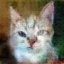

**Single output/generated - Failed imaged**



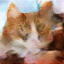

**Single output/generated - Failed imaged**


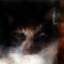